Imports

In [2]:
from typing import Tuple
import math

import numpy as np
from numpy.random import randint, uniform

from skimage.draw import polygon, circle_perimeter_aa, circle, circle_perimeter

import imageio as iio

import matplotlib.pyplot as plt
%matplotlib inline

import numba

import conf

# Common definitions

In [3]:
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['figure.dpi'] = 96

# rng = default_rng()

ORIGINAL_IMAGE = iio.imread(conf.IMAGE_PATH)
ORIGINAL_IMAGE_DIMENSIONS = (ORIGINAL_IMAGE.shape[0], ORIGINAL_IMAGE.shape[1])

INITIAL_NUM_POLYGONS = int(conf.INITIAL_NUM_POLYGONS_SCALE *\
  (ORIGINAL_IMAGE_DIMENSIONS[0] * ORIGINAL_IMAGE_DIMENSIONS[1]))

## Helper functions

In [4]:
@numba.njit()
def get_random_num_polygon_vertices(n: int) -> np.ndarray:
  return randint(
    conf.MIN_NUM_POLYGON_VERTICES,
    conf.MAX_NUM_POLYGON_VERTICES,
    n
  )

@numba.njit()
def get_random_circumscribed_circle_radius(n: int) -> np.ndarray:
  return randint(
    conf.MIN_CIRCUMSCRIBED_CIRCLE_SIZE,
    conf.MAX_CIRCUMSCRIBED_CIRCLE_SIZE,
    n
  )

@numba.njit()
def get_random_color(n: int) -> np.ndarray:
  return randint(0, 256, (n, 3))

@numba.njit()
def get_random_coordinates_on_image(
  limiter,
  image_dimensions = ORIGINAL_IMAGE_DIMENSIONS
) -> np.ndarray:
  return np.array([
    randint(limiter, image_dimensions[0] - limiter),
    randint(limiter, image_dimensions[1] - limiter),
  ])

Define the parallelized methods.

In [38]:
@numba.njit()
def generate_random_polygon(
  num_points: int,
  circle_radius: int,
  circle_center_position: np.ndarray,
) -> np.ndarray:
  points = numba.typed.List()

  for _ in range(num_points):
    angle = uniform(0, 2 * np.pi)
    base_x = circle_radius * math.sin(angle)
    base_y = circle_radius * math.cos(angle)
    x, y = circle_center_position + np.array([base_x, base_y])

    points.append((x, y, angle))

  points.sort(lambda x: x[2])
  points = list(points)

  return np.array(points, dtype=np.int64)[:,0:2]

@numba.njit(parallel=True)
def generate_random_circles(
  num_circles: int,
) -> np.ndarray:
  circles = np.empty((num_circles, 3), dtype=np.int64)

  for i in numba.prange(num_circles):
    radius = get_random_circumscribed_circle_radius(1)
    circle_coordinates = get_random_coordinates_on_image(radius[0])
    circle = np.append(circle_coordinates, radius)
    circles[i] = circle

  return circles

@numba.njit(parallel=True)
def generate_random_polygons(
  circles: np.ndarray
) -> np.ndarray:
  polygons = np.zeros((circles.shape[0], conf.MAX_NUM_POLYGON_VERTICES, 2), dtype=np.int64)

  for i in numba.prange(circles.shape[0]):
  # for i in range(circles.shape[0]):
    num_vertices = get_random_num_polygon_vertices(1)

    # print(num_vertices)
    # print(circles)
    # print(f"Radius = {circles[i, 2]}")
    # print(f"Coordinates = {circles[i, 0:2]}")

    polygon = generate_random_polygon(
      num_vertices[0],
      circles[i, 2],
      circles[i, 0:2],
    )

    wrapped_size = np.array((num_vertices[0], 0), dtype=np.int64).reshape(1, 2)
    points_with_size = np.append(wrapped_size, polygon, 0)
    rest = conf.MAX_NUM_POLYGON_VERTICES - points_with_size.shape[0]
    polygons[i] = np.append(
      points_with_size,
      np.zeros(
        (rest, 2),
        dtype=np.int64),
      0
    )

  return polygons

Define the necessary data structures

In [62]:
class ImagePolygon:
  """Contains the information to represent polygon on an image.
  Is used as gene of a chromosome.

  Attributes:
    points  Numpy array of points (numpy arrays of length 2) of an
      underlying polygon.
    color   Numpy array of 3 elements, which correspond to red, green and
      blue channels. The values must be in range 0-255.
    circumscribed_circle_center  Numpy array of length 2, containing
      coordinates of the circumscribed circle.
    circumscribed_circle_radius  Circumscribed circle radius.
  """

  points: np.ndarray
  color: np.ndarray
  circumscribed_circle_center: np.ndarray
  circumscribed_circle_radius: int

  def __init__(
    self,
    points:                 np.ndarray = None,
    circle_radius:          int        = None,
    circle_center_position: np.ndarray = None,
    num_points:             int        = None,
    color:                  np.ndarray = None,
  ):
    """ Initializes a polygon for the given parameters.
    All vertices of the polygon lie on the circumscribed circle.

    :param circle_center_position: A numpy array containing a pair of coordinates
      which correspond to the center of the circumscribed circle.
      If None, defaults to get_random_coordinates_on_image(circle_radius).
    :param circle_radius: Radius of the circumscribed circle.
      If None, defaults to `get_random_circumscribed_circle_radius()`.
    :param num_points: Number of polygon vertices.
      If None, defaults to `get_random_num_polygon_vertices()`.
    :param color: Numpy array of 3 elements, which correspond to red, green
      and blue channels. The values must be in range 0-255.
      If None, defaults to `get_random_color()`.
    """
    if circle_radius is None:
      circle_radius = get_random_circumscribed_circle_radius()

    if circle_center_position is None:
      circle_center_position = get_random_coordinates_on_image(circle_radius)

    if num_points is None:
      num_points = get_random_num_polygon_vertices(1)

    if color is None:
      color = get_random_color()

    if points is None:
      points = generate_random_polygon(
        num_points,
        circle_radius,
        circle_center_position,
      )

    self.points = points
    self.color = color
    self.circumscribed_circle_center = circle_center_position
    self.circumscribed_circle_radius = circle_radius

  def __repr__(self):
    return self.points, self.color

  def __str__(self):
    return "\n".join([
      str(self.points),
      f"Color: {self.color}",
      "Circumscribed circle:\n" +
        "\n".join([
          f"\tCenter {self.circumscribed_circle_center}",
          f"\tRadius {self.circumscribed_circle_radius}"
        ])
    ])

  def draw_on_image(self, img: np.ndarray) -> None:
    """Draws this polygon on the given image.

    :param img: Numpy array of size `n x m x 3`, representing a rgb image of
      size `n x m`.
    """
    p_x, p_y = polygon(self.points[:,0], self.points[:,1])
    img[p_x, p_y] = self.color


class Chromosome:
  """Chromosome for the genetic algorithm. Can be represented as an image.

  Consists of the polygons that constitute the underlying image.

  Attributes:
    polygons  Numpy array of polygons on the image.
    image_dimensions  Number of pixels of the underlying image by x and y
      coordinates respectively.
  """

  polygons: np.ndarray
  image_dimensions: Tuple[int, int]

  def __init__(self,
    image_dimensions: Tuple[int, int] = None,
    num_polygons: int = None
  ):
    """Initializes a chromosome by generating an image from random polygons.

    :param image_dimensions: Number of pixels of the underlying image by x
      and y coordinates respectively.
    :param num_polygons: Number of polygons to generate on the image.
    """
    if image_dimensions is None:
      image_dimensions = ORIGINAL_IMAGE_DIMENSIONS

    if num_polygons is None:
      num_polygons = INITIAL_NUM_POLYGONS

    random_circles = generate_random_circles(num_polygons)
    random_polygons = generate_random_polygons(random_circles)
    random_colors = get_random_color(num_polygons)

    self.polygons = np.empty(random_circles.shape[0], dtype=np.object)

    for i, polygon_props in enumerate(zip(random_circles, random_polygons, random_colors)):
      polygon_points = polygon_props[1][1:polygon_props[1][0, 0] + 1,:]
      circle_radius = polygon_props[0][2]
      circle_center_coordinates = polygon_props[0][0:2]

      self.polygons[i] = ImagePolygon(
        points=polygon_points,
        circle_radius=circle_radius,
        circle_center_position=circle_center_coordinates,
        color=polygon_props[2],
      )

    self.image_dimensions = image_dimensions

  def to_image(self, background = np.array([255, 255, 255])) -> np.ndarray:
    """Converts the chromosome to a numpy array by drawing the polygons
    on an image with the given background.

    :param background: Numpy array of size 3, which represents a background
      color of the resulting image.
    :return: Numpy array with the drawn polygons.
    """
    image = np.full(self.image_dimensions + (3,), background)

    for polygon in self.polygons:
      polygon.draw_on_image(image)

    return image


class Population:
  chromosomes: np.ndarray

  def __init__(
    self,
    population_size: int = conf.POPULATION_SIZE
  ):
    pass

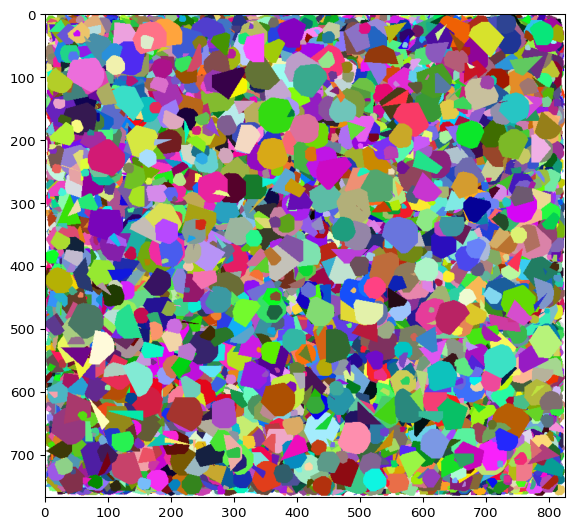

In [67]:
# Trash

c = Chromosome()
img = c.to_image()
plt.imshow(img.clip(0, 255).astype('uint8'))

# TODOs

- [ ] generate the **initial population**
- [ ] implement the **main loop** for the GA
- [ ] implement the **fitness function**
- [ ] implement the **mutation** method for a `Chromosome`
  - add new polygon
  - remove an existing polygon
  - change an existing polygon
    - reshape
    - change color
  - move an existing polygon
- [ ] implement the **crossover** method for a `Chromosome`
- [ ] implement the **selection** method for a population